# This notebook is attempting to create some dummy image data

Code is based off Demos/HRTEM.ipynb

In [4]:
import pyms
import numpy as np
import torch
from copy import deepcopy

Where is pyms.structure? Answer: pyms.structure_routines (it is a a class)

    def fromfile(
        cls,
        fnam,
        temperature_factor_units="ums",
        atomic_coordinates="fractional",
        EPS=1e-2,
        T=None,
    ):
    
First argument is the class, second is the filename; however below it looks like
Structures are housed in Demos/Structures

There are a variety of different crystal structures which are possible, including:
- 1000048.p1
- 1svm.p1
- Bournonite_DW.xyz
- ESMO_LSMO.p1
- Si100.xyz
- SrTiO3.xyz
- SrTiO3_CeO2_interface.xyz
- YBCO.p1
- YBCO_no_frac_occ.p1

This is what SrTiO3.xyz looks like:

    SrTiO3
       3.905000   3.905000   3.905000   90.0000   90.0000   90.0000
    38 0.000000  0.000000  0.000000 1.0 0.7870e-2
    22 0.500000  0.500000  0.500000 1.0 0.5570e-2
    8  0.500000  0.500000  0.000000 1.0 0.9275e-2
    8  0.500000  0.000000  0.500000 1.0 0.9275e-2
    8  0.000000  0.500000  0.500000 1.0 0.9275e-2
    -1

<b>fromfile function:</b>
1. Extracts the file type/extension (e.g. .p1, .xyz, etc)
2. Takes the first line as the a, b, c, alpha, beta, gamma unit cell type
3. From the next line, takes the first column as the atomic number of the element, the next 3 columns as position, 4th column is the "fractional occupancy" and 5th column is the "<i>Debye-Waller (temperature) factor</i>"
4. -1 is the end of file marker

Notes: The Debye-Waller (temperature) factors accounts for the displacements of atoms from their idealized positions due to vibrations.

In [6]:
# Get crystal
crystal = pyms.structure.fromfile(
    "/home/hremadmin/py_multislice_differentiable/py_multislice_differentiable_tem/Demos/Structures/SrTiO3_CeO2_interface.xyz",
    atomic_coordinates="cartesian"
)

# A few maniupulations to remove vaccuum at edges and create a psuedo-periodic
# structure
crystal = crystal.resize([0.1, 0.76], axis=0)

other = deepcopy(crystal).resize([0.017, 0.99], axis=0)
other.reflect([0])
crystal = crystal.concatenate(other, axis=0)


In [13]:
# Output structure for examination in Vesta
# crystal.output_vesta_xtl("manipulated.xtl")

# Quick plot of crystal
# crystal.quickplot(atomscale=1e-5)

# Subslicing of crystal for multislice
subslices = [0.33, 0.66, 1.0]

# Grid size in pixels
gridshape = [1024, 1024]

# Tile structure in multislice for a square grid
tiling = [1, 7]

# Probe accelerating voltage in eV
eV = 3e5

# Objective aperture in mrad
app = 15

# No aperture is also an option
# app = None

# Set up series of thicknesses
thicknesses = np.array([100])

# Establish defocus
df = torch.tensor([100.0])

# Number of frozen phonon passes
nfph = 25

output = pyms.HRTEM(
    crystal,
    gridshape,
    eV,
    app,
    thicknesses,
    subslices=subslices,
    aberrations=[],
    df=df,
    tiling=tiling,
    nfph=25,
    showProgress='notebook'
)

import matplotlib.pyplot as plt
%matplotlib inline
ny,nx = output.shape[-2:]

#plt.imshow(output) # failing on this line

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

0


Frozen phonon iteration:   0%|          | 0/25 [00:00<?, ?it/s]

In [17]:
# Output is a tensor?
# Convert to a numpy array

data_to_save = output.cpu().detach().numpy()

In [19]:
# Need to somehow save it as a npy

# is nx and ny the right data

filename = "Lowena_practice_dummy_data.npy"

np.save(filename, data_to_save)

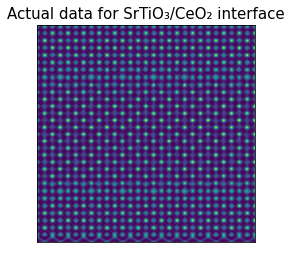

In [22]:
# TRying saving then reloadng it back in

path = '/home/hremadmin/py_multislice_differentiable/py_multislice_differentiable_tem/Demos/Part_1_Just_Defocus/Lowena_practice_dummy_data.npy'
ref_data = np.load(path)
ref_data = torch.tensor(ref_data).to('cpu')

plt.imshow(torch.abs(ref_data).numpy()) # removed .cpu and .detach and vmax=10 (vmax was the thing causing issues)

plt.title(u'Actual data for SrTiO\u2083/CeO\u2082 interface', fontsize=15)
plt.xticks([])
plt.yticks([])

filepath = "/home/hremadmin/Documents/Project/ML_files/lowena_dummy_image.jpg"
plt.savefig(filepath, dpi=500)

# Doesn't look how I'd expect